# Compare RL Control with PID Control tuned by RL <br> / RL Control과 RL로 튜닝한 PID Control 비교

In [14]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import cv2
import time
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## Check state[4] (angle) / state[4] (각도) 확인하기

Befor Setting angle as set point of PID control, check what angle is.

In [15]:
env = gym.make("LunarLander-v2")

In [16]:
'''
s[0] is the horizontal coordinate
s[1] is the vertical coordinate
s[2] is the horizontal speed
s[3] is the vertical speed
s[4] is the angle
s[5] is the angular speed
s[6] 1 if first leg has contact, else 0
s[7] 1 if second leg has contact, else 0
'''

'\ns[0] is the horizontal coordinate\ns[1] is the vertical coordinate\ns[2] is the horizontal speed\ns[3] is the vertical speed\ns[4] is the angle\ns[5] is the angular speed\ns[6] 1 if first leg has contact, else 0\ns[7] 1 if second leg has contact, else 0\n'

In [17]:
env.reset()
angles = []
imgs = []
for _ in range(50):
    result = env.step(1)
    angles.append(result[0][4])
    imgs.append(env.render(mode='rgb_array'))
env.close()

In [18]:
def check_angle(angles, imgs):
    T = 50
    plt.figure(figsize=(10,400))
    for i in range(T):
        ax = plt.subplot(T,1,i+1)
        ax.set_title(str(angles[i]))
        ax.imshow(imgs[i])

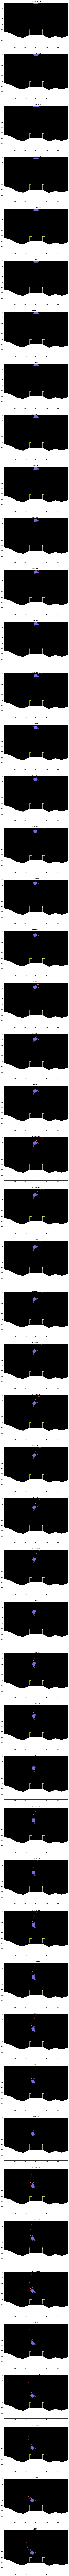

In [19]:
check_angle(angles,imgs)

In [20]:
env.reset()
angles = []
imgs = []
for _ in range(50):
    result = env.step(3)
    angles.append(result[0][4])
    imgs.append(env.render(mode='rgb_array'))
env.close()

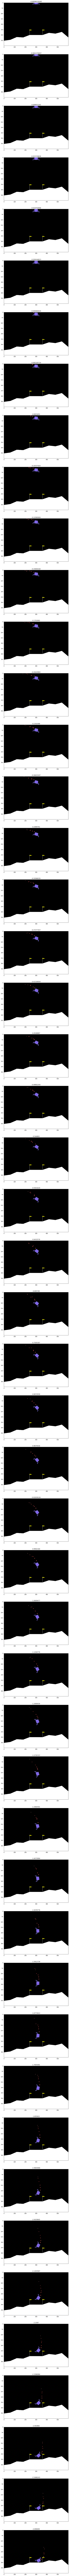

In [21]:
check_angle(angles, imgs)

In [22]:
state = env.reset()
origin_vertical = state[1]
origin_horizontal = state[0]
done = False
action = 0

main_engine_on_during = 5
main_engine_on_count = 0

side_engine_on_during = 20
side_engine_on_count = 0


print('origin : ',origin_horizontal)
print()

while not done:
    env.render()
    n_state, reward, done, info = env.step(action)
    if n_state[5]<0:
        action=1
    else:
        action=3
    
    if side_engine_on_count%side_engine_on_during == 0:
        if n_state[2] < 0:
            action=3
        elif n_state[2] > 0:
            action=1
    side_engine_on_count += 1
    
    if n_state[3] < 0 and main_engine_on_count%main_engine_on_during != 0:
        action=2
    main_engine_on_count += 1
    
    time.sleep(0.01)
    
    print(f'angular speed:{n_state[5]:+0.3f}, horizontal cord:{n_state[0]:+0.3f}, horizontal speed:{n_state[2]:+0.3f},vertical speed:{n_state[3]:+0.3f}', end='\r')
    
env.close()

origin :  -0.00416317



## Check continuous action space / 연속 행동 공간에서 살펴보기

In [23]:
cenv = gym.make("LunarLanderContinuous-v2")

In [24]:
state = cenv.reset()
origin_vertical = state[1]
origin_horizontal = state[0]
done = False
action = [0,0]

while not done:
    cenv.render()
    n_state, reward, done, info = cenv.step(action)
    if n_state[5]<0:
        action[1]=n_state[5]*50 + (2 - (n_state[2]<0) + (n_state[2]>0)) * -n_state[2]*10 + (2 - (n_state[0]<0) + (n_state[0]>0)) * -n_state[0]
    elif n_state[5]>0: 
        action[1]=n_state[5]*50 + (2 - (n_state[2]<0) + (n_state[2]>0)) * -n_state[2]*10 + (2 - (n_state[0]<0) + (n_state[0]>0)) * -n_state[0]
        
    if n_state[3]<0:
        action[0]=abs(n_state[3])*5
        
    time.sleep(0.01)
    
    print(f'action:[{action[0]:+0.2f},{action[1]:+0.2f}], a s:{n_state[5]:+0.3f}, h c:{n_state[0]:+0.3f}, h s:{n_state[2]:+0.3f},v s:{n_state[3]:+0.3f}', end='\r')
    
cenv.close()

## Apply PID control to side engines + apply keyboard control  <br> / Side engines에 PID control 적용 + 키보드 조작 적용

In [25]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import cv2
import time

from PID import PID

cenv = gym.make("LunarLanderContinuous-v2")

SKIP_CONTROL = 0    # Use previous control decision SKIP_CONTROL times, that's how you
                    # can test what skip is still usable.

side_engine_control = 0
main_engine_control = 0
engine_off = False

human_wants_restart = False
human_sets_pause = False

'''
    a : left(right side engine on)
    d : right(left side engine on)
    s : down(main engine power down)
    w : up(main engine power up)
    q : engine off
'''

def key_press(key, mod):
    global side_engine_control, main_engine_control, engine_off, human_wants_restart, human_sets_pause
    if key==0xff0d: human_wants_restart = True  # Enter
    if key==32: human_sets_pause = not human_sets_pause # Space
    a = int(key)
    if a <= 0: return
    if a==ord('a'):
        side_engine_control = 0.3
    if a==ord('d'):
        side_engine_control = -0.3
    if a==ord('s'):
        main_engine_control = -0.3
    if a==ord('w'):
        main_engine_control = 0.3
    if a==ord('q'):
        engine_off=True

def key_release(key, mod):
    global side_engine_control, main_engine_control, engine_off
    if side_engine_control == -0.3 or side_engine_control == 0.3:
        side_engine_control = 0
    if main_engine_control == -0.3 or main_engine_control == 0.3:
        main_engine_control = 0
    if engine_off == True:
        engine_off = False

cenv.render()
cenv.unwrapped.viewer.window.on_key_press = key_press
cenv.unwrapped.viewer.window.on_key_release = key_release

def rollout(env):
    global side_engine_control, main_engine_control, engine_off, human_wants_restart, human_sets_pause
    
    human_wants_restart = False
    
    state = cenv.reset()
    done = False
    action = [0,0]
    
    # apply PID
    apid = PID(1.253136190601821, 0.620026107056804, -0.002720052821954503)
    vpid = PID(1.253136190601821, 0.620026107056804, -0.002720052821954503)
    apid.SetPoint=0
    vpid.SetPoint=0
    
    # cummulated reward
    cr = 0
    
    # PID plots
    apid_sp_list, apid_fb_list = [], []
    vpid_sp_list, vpid_fb_list = [], []

    while not done:
     
        window_still_open = cenv.render()
        n_state, reward, done, info = cenv.step(action)
        
        # PID control
        apid.SetPoint=side_engine_control
        vpid.SetPoint=main_engine_control
        
        apid_sp_list.append(apid.SetPoint)
        vpid_sp_list.append(vpid.SetPoint)

        apid.update(n_state[4])
        action[1] = (-apid.output*2.5 + n_state[5])*20

        vpid.update(n_state[3])
        action[0] = vpid.output
        
        apid_fb_list.append(n_state[4])
        vpid_fb_list.append(n_state[3])

        time.sleep(0.01)

        if engine_off:
            action = [0, 0]

        print(f'action:[{action[0]:+0.2f},{action[1]:+0.2f}], as:{n_state[5]:+0.3f},vs:{n_state[3]:+0.3f}, vsp:{vpid.SetPoint:+0.1f}, asp:{apid.SetPoint:+0.1f}', end='\r')
        cr+=reward
        
        if window_still_open==False: return False
        if human_wants_restart: break
        while human_sets_pause:
            cenv.render()
            time.sleep(0.1)
    print()
    print("reward:",cr)
    
    return apid_sp_list, apid_fb_list, vpid_sp_list, vpid_fb_list

apid_sp_list, apid_fb_list, vpid_sp_list, vpid_fb_list = window_still_open = rollout(cenv)
cenv.close()

action:[+0.00,+0.00], as:+0.000,vs:+0.000, vsp:+0.0, asp:+0.00
reward: 173.08778331275693


### Check PID plots

In [ ]:
plt.ylim(-1,1)
plt.plot(vpid_sp_list)
plt.plot(vpid_fb_list)

In [ ]:
plt.ylim(-0.5,0.5)
plt.plot(apid_sp_list)
plt.plot(apid_fb_list)

## 학습을 위한 환경 구축하기

1. 균형 유지 Contorler
2. 고도 유지 Contorler

- 실험1. reward를 SetPoint와 실제값의 차로 결정. Setpoint가 0일때로 학습시킨 다음 SetPoint를 바꾸면 잘 작동할까?

In [2]:
# 실험1을 위한 환경 구성
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from gym.envs.box2d.lunar_lander import *

In [3]:
class ControlableLunarLander(LunarLander):
    
    continuous = True
    
    def __init__(self):
        self.a_set_point = 0
        self.v_set_point = 0
        super(ControlableLunarLander, self).__init__()
        
    def change_set_points(self, key):
        if key==ord('a'):
            self.a_set_point = 0.3
        if key==ord('d'):
            self.a_set_point = -0.3
        if key==ord('s'):
            self.v_set_point = -0.3
        if key==ord('w'):
            self.v_set_point = 0.3
        
    # Modify Step
    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (action, type(action))

        # Engines
        tip  = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (not self.continuous and action == 2):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0,1.0) + 1.0)*0.5   # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (tip[0] * (4/SCALE + 2 * dispersion[0]) +
                  side[0] * dispersion[1])  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4/SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(3.5,  # 3.5 is here to make particle speed adequate
                                      impulse_pos[0],
                                      impulse_pos[1],
                                      m_power)  # particles are just a decoration
            p.ApplyLinearImpulse((ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                                 impulse_pos,
                                 True)
            self.lander.ApplyLinearImpulse((-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                                           impulse_pos,
                                           True)

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (not self.continuous and action in [1, 3]):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action-2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (3 * dispersion[1] + direction * SIDE_ENGINE_AWAY/SCALE)
            oy = -tip[1] * dispersion[0] - side[1] * (3 * dispersion[1] + direction * SIDE_ENGINE_AWAY/SCALE)
            impulse_pos = (self.lander.position[0] + ox - tip[0] * 17/SCALE,
                           self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT/SCALE)
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse((ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                                 impulse_pos
                                 , True)
            self.lander.ApplyLinearImpulse((-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                                           impulse_pos,
                                           True)

        self.world.Step(1.0/FPS, 6*30, 2*30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2),
            (pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_H/SCALE/2),
            vel.x*(VIEWPORT_W/SCALE/2)/FPS,
            vel.y*(VIEWPORT_H/SCALE/2)/FPS,
            self.lander.angle,
            20.0*self.lander.angularVelocity/FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0
            ]
        assert len(state) == 8

        reward_a = 1 if abs(self.a_set_point - state[4]) < 0.05 else -1
        reward_v = 1 if abs(self.v_set_point - state[3]) < 0.1 else -1

        done = False
        if self.game_over or abs(state[0]) >= 1.0:
            done = True
            reward_v -= 100
        if not self.lander.awake:
            done = True
        return np.array(state, dtype=np.float32), [reward_v, reward_a], done, {}

### demo 실행 

In [ ]:
# Modify Demo
def demo_heuristic_lander(env, seed=None, render=False):
    env.seed(seed)
    total_reward = [0,0]
    steps = 0
    s = env.reset()
    while True:
        a = heuristic(env, s)
        s, r, done, info = env.step(a)
        total_reward[0] += r[0]
        total_reward[1] += r[1]

        if render:
            still_open = env.render()
            if still_open == False: break

        if steps % 20 == 0 or done:
            print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("step {} total_reward {}".format(steps, total_reward))
        steps += 1
        if done: break
    env.close()
    return total_reward

In [ ]:
demo_heuristic_lander(ControlableLunarLander(), render=True)

### 간단한 학습을 위한 A2C 구현 

In [4]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Lambda
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
class ActorNetwork(Model):
    def __init__(self, action_dim, action_bound):
        super(ActorNetwork, self).__init__()
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(32, activation='relu')
        self.d3 = Dense(16, activation='relu')
        self.out_mu = Dense(action_dim, activation='tanh')
        self.mu_adjust = Lambda(lambda x: x * action_bound)
        self.std_output = Dense(action_dim, activation='softplus')

    def call(self, i):
        output = self.d1(i)
        output = self.d2(output)
        output = self.d3(output)
        mu_output = self.out_mu(output)
        return self.mu_adjust(mu_output), self.std_output(output)

class Actor(object):
    """
        A2C Actor Neural Net
    """

    def __init__(self, state_dim, action_dim, action_bound, learning_rate):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate

        # set min and max of standard deviation
        self.std_bound = [1e-2, 1.0]

        # create actor neural net
        self.model = ActorNetwork(self.action_dim, self.action_bound)

        """
        tf 2.0
        """

        # loss and optimizer
        self.actor_optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

    def train(self, states, actions, advantages):
        with tf.GradientTape() as g:
            mu_a, std_a = self.model(states)
            log_policy_pdf = self.log_pdf(mu_a, std_a, actions)
            loss_policy = log_policy_pdf * advantages
            loss = tf.reduce_sum(-loss_policy)
        dj_dtheta = g.gradient(loss, self.model.trainable_weights)
        grads = zip(dj_dtheta, self.model.trainable_weights)
        self.actor_optimizer.apply_gradients(grads)

    def model_initializer(self, state):
        self.states = state

    # log_policy pdf
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std**2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    # get action
    def get_action(self, state):
        mu_a, std_a = self.model(np.reshape(state, [1, self.state_dim]))
        mu_a = mu_a[0]
        std_a = std_a[0]

        std_a = tf.clip_by_value(std_a, self.std_bound[0], self.std_bound[1])
        action = np.random.normal(mu_a, std_a, size=self.action_dim)
        return action

    # calculate mean
    def predict(self, state):
        mu_a, _ = self.model(np.reshape(state, [1, self.state_dim]))
        return mu_a[0]

    # save Actor parameter
    def save_weights(self, path):
        self.model.save_weights(path)

    # load Actor parameter
    def load_weights(self, path):
        self.model.load_weights(path)


In [6]:
class CriticNetwork(Model):
    def __init__(self):
        super(CriticNetwork, self).__init__()
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(32, activation='relu')
        self.d3 = Dense(16, activation='relu')
        self.v_output = Dense(1, activation='linear')

    def call(self, inputs):
        output = self.d1(inputs)
        output = self.d2(output)
        output = self.d3(output)
        return self.v_output(output)

class Critic(object):

    """
        A2C Critic Neural Net
    """

    def __init__(self, state_dim, action_dim, learning_rate):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate

        # create critic neural net
        self.model = CriticNetwork()

        # set training method
        self.model.compile(optimizer=Adam(self.learning_rate), loss='mse')

    # update neural net with batch data
    def train_on_batch(self, states, td_targets):
        return self.model.train_on_batch(states, td_targets)

    # save Critic parameter
    def save_weights(self, path):
        self.model.save_weights(path)

    # load Critic parameter
    def load_weights(self, path):
        self.model.load_weights(path)

#### Training Angle Controller 

In [ ]:
class A2CAngleController(object):

    def __init__(self, env):

        # hyperparameter
        self.GAMMA = 0.95
        self.BATCH_SIZE = 32
        self.ACTOR_LEARNING_RATE = 0.0001
        self.CRITIC_LEARNING_RATE = 0.001

        # environment
        self.env = env
        # state dimension
        self.state_dim = 2
        # action dimension
        self.action_dim = env.action_space.shape[0]
        # max action size
        self.action_bound = env.action_space.high[0]

        self.single_engine_action_dim = 1
            
        # create Actor and Critic neural nets
        self.actor = Actor(self.state_dim, self.single_engine_action_dim, self.action_bound, self.ACTOR_LEARNING_RATE)
        self.critic = Critic(self.state_dim, self.single_engine_action_dim, self.CRITIC_LEARNING_RATE)

        # total reward of a episode
        self.save_epi_reward = []

    # calculate advantages and TD targets
    def advantage_td_target(self, reward, v_value, next_v_value, done):
        if done:
            y_k = reward
            advantage = y_k - v_value
        else:
            y_k = reward + self.GAMMA * next_v_value
            advantage = y_k - v_value
        return advantage, y_k

    # extract data from batch
    def unpack_batch(self, batch):
        unpack = batch[0]
        for idx in range(len(batch)-1):
            unpack = np.append(unpack, batch[idx+1], axis=0)
        return unpack

    # train agent
    def train(self, max_episode_num):

        # repeat for each episode
        for ep in range(int(max_episode_num)):

            # init batch
            batch_state, batch_action, batch_td_target, batch_advantage = [], [], [] ,[]
            # init episode
            time, episode_reward, done = 0, 0, False
            # reset env and observe initial state
            state = self.env.reset()
            state = state[4:6]    # angle, angular speed

            while not done:

                # visualize env
                self.env.render()
    
                # get action
                side_engine_action = self.actor.get_action(state) 
                action = [0, side_engine_action[0]]
                
                # bound action range
                action = np.clip(action, -self.action_bound, self.action_bound)
            

                # observe next state, reward
                next_state, reward, done, _ = self.env.step(action)
                reward = reward[1] # angle reward
                if time > 200:
                    done = True 

                # reshape
                state = np.reshape(state, [1, self.state_dim])
                next_state = np.reshape(next_state[4:6], [1, self.state_dim])
                action = np.reshape(action, [1, self.action_dim])
                reward = np.reshape(reward, [1, 1])

                # calculate state value
                v_value = self.critic.model(state)
                next_v_value = self.critic.model(next_state)

                # calculate advantage and TD target
                train_reward = (reward+8)/8
                advantage, y_i = self.advantage_td_target(train_reward, v_value, next_v_value, done)

                # append to batch
                batch_state.append(state)
                batch_action.append(action)
                batch_td_target.append(y_i)
                batch_advantage.append(advantage)

                # wait for full batch
                if len(batch_state) < self.BATCH_SIZE:

                    # update state
                    state = next_state[0]
                    episode_reward += reward[0]
                    time += 1
                    continue

                # train
                # extract from batch
                states = self.unpack_batch(batch_state)
                actions = self.unpack_batch(batch_action)
                td_targets = self.unpack_batch(batch_td_target)
                advantages = self.unpack_batch(batch_advantage)

                # clear batch
                batch_state, batch_action, batch_td_target, batch_advantage = [], [], [], []

                # critic neural net update
                self.critic.train_on_batch(states, td_targets)

                # actor neural net update
                self.actor.train(states, actions, advantages)

                # update state
                state = next_state[0]
                episode_reward += reward[0]
                time += 1

            print('Episode: ', ep+1, 'Time: ', time, 'Reward: ', episode_reward)
            self.save_epi_reward.append(episode_reward)

            # save neural net parameters
            if ep % 10 == 0:
                state_for_check = np.reshape(state, [1, self.state_dim])
                print("Critic value: ", self.critic.model(state_for_check))

    # graph episodes and rewards
    def plot_result(self):
        plt.plot(self.save_epi_reward)
        plt.show()

In [ ]:
# Training Balancing Agent
max_episode_num = 5000

env = ControlableLunarLander()
balancing_agent = A2CAngleController(env)

# train
balancing_agent.train(max_episode_num)

# result
balancing_agent.plot_result()

env.close()

#### 특이한점

8개의 state 전부를 줄 때는 학습이 안됬는데, angle, angular speed 이 2개로 state를 주니까 학습이 됨.

In [ ]:
balancing_agent.actor.save_weights('./saved_weights/ll_side_engine_actor.h5')
balancing_agent.critic.save_weights('./saved_weights/ll_side_engine_critic.h5')

#### Training Vertical Controller 

In [7]:
class VerticalActorNetwork(Model):
    def __init__(self, action_dim, action_bound):
        super(ActorNetwork, self).__init__()
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(32, activation='relu')
        self.d3 = Dense(16, activation='relu')
        self.out_mu = Dense(action_dim, activation='sigmoid')
        self.mu_adjust = Lambda(lambda x: x * action_bound)
        self.std_output = Dense(action_dim, activation='softplus')

    def call(self, i):
        output = self.d1(i)
        output = self.d2(output)
        output = self.d3(output)
        mu_output = self.out_mu(output)
        return self.mu_adjust(mu_output), self.std_output(output)

class VerticalActor(object):
    """
        A2C Actor Neural Net
    """

    def __init__(self, state_dim, action_dim, action_bound, learning_rate):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate

        # set min and max of standard deviation
        self.std_bound = [1e-2, 1.0]

        # create actor neural net
        self.model = ActorNetwork(self.action_dim, self.action_bound)

        """
        tf 2.0
        """

        # loss and optimizer
        self.actor_optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

    def train(self, states, actions, advantages):
        with tf.GradientTape() as g:
            mu_a, std_a = self.model(states)
            log_policy_pdf = self.log_pdf(mu_a, std_a, actions)
            loss_policy = log_policy_pdf * advantages
            loss = tf.reduce_sum(-loss_policy)
        dj_dtheta = g.gradient(loss, self.model.trainable_weights)
        grads = zip(dj_dtheta, self.model.trainable_weights)
        self.actor_optimizer.apply_gradients(grads)

    def model_initializer(self, state):
        self.states = state

    # log_policy pdf
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std**2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    # get action
    def get_action(self, state):
        mu_a, std_a = self.model(np.reshape(state, [1, self.state_dim]))
        mu_a = mu_a[0]
        std_a = std_a[0]

        std_a = tf.clip_by_value(std_a, self.std_bound[0], self.std_bound[1])
        action = np.random.normal(mu_a, std_a, size=self.action_dim)
        return action

    # calculate mean
    def predict(self, state):
        mu_a, _ = self.model(np.reshape(state, [1, self.state_dim]))
        return mu_a[0]

    # save Actor parameter
    def save_weights(self, path):
        self.model.save_weights(path)

    # load Actor parameter
    def load_weights(self, path):
        self.model.load_weights(path)


In [9]:
class A2CVerticalController(object):

    def __init__(self, env):

        # hyperparameter
        self.GAMMA = 0.95
        self.BATCH_SIZE = 32
        self.ACTOR_LEARNING_RATE = 0.0001
        self.CRITIC_LEARNING_RATE = 0.001

        # environment
        self.env = env
        # state dimension
        self.state_dim = 2
        # action dimension
        self.action_dim = env.action_space.shape[0]
        # max action size
        self.action_bound = env.action_space.high[0]

        self.single_engine_action_dim = 1
            
        # create Actor and Critic neural nets
        self.actor = VerticalActor(self.state_dim, self.single_engine_action_dim, self.action_bound, self.ACTOR_LEARNING_RATE)
        self.critic = Critic(self.state_dim, self.single_engine_action_dim, self.CRITIC_LEARNING_RATE)
        
        # load Balancing Actor neural net
        self.balancing_actor = Actor(self.state_dim, self.single_engine_action_dim, self.action_bound, self.ACTOR_LEARNING_RATE)
        
        # total reward of a episode
        self.save_epi_reward = []

    # calculate advantages and TD targets
    def advantage_td_target(self, reward, v_value, next_v_value, done):
        if done:
            y_k = reward
            advantage = y_k - v_value
        else:
            y_k = reward + self.GAMMA * next_v_value
            advantage = y_k - v_value
        return advantage, y_k

    # extract data from batch
    def unpack_batch(self, batch):
        unpack = batch[0]
        for idx in range(len(batch)-1):
            unpack = np.append(unpack, batch[idx+1], axis=0)
        return unpack

    # train agent
    def train(self, max_episode_num):

        # repeat for each episode
        for ep in range(int(max_episode_num)):

            # init batch
            batch_state, batch_action, batch_td_target, batch_advantage = [], [], [] ,[]
            # init episode
            time, episode_reward, done = 0, 0, False
            # reset env and observe initial state
            state = self.env.reset()
            a_state = state[4:6] # state for balancing actor
            state = [state[1], state[3]] # vertical coord, vertical speed
            
            if ep == 1:
                self.balancing_actor.load_weights('./saved_weights/ll_side_engine_actor.h5')

            while not done:

                # visualize env
                self.env.render()
    
                # get action
                side_engine_action = self.balancing_actor.get_action(a_state) # angle action
                main_engine_action = self.actor.get_action(state)
                action = [0.3 + main_engine_action[0], side_engine_action[0]]
                
                # bound action range
                action = np.clip(action, -self.action_bound, self.action_bound)
            

                # observe next state, reward
                next_state, reward, done, _ = self.env.step(action)
                reward = reward[0]
                if time > 200:
                    done = True 

                # reshape
                state = np.reshape(state, [1, self.state_dim])
                a_state = np.reshape(next_state[4:6], [1, self.state_dim])
                next_state = np.reshape([next_state[1], next_state[3]], [1, self.state_dim])
                action = np.reshape(action, [1, self.action_dim])
                reward = np.reshape(reward, [1, 1])

                # calculate state value
                v_value = self.critic.model(state)
                next_v_value = self.critic.model(next_state)

                # calculate advantage and TD target
                train_reward = (reward+8)/8
                advantage, y_i = self.advantage_td_target(train_reward, v_value, next_v_value, done)

                # append to batch
                batch_state.append(state)
                batch_action.append(action)
                batch_td_target.append(y_i)
                batch_advantage.append(advantage)

                # wait for full batch
                if len(batch_state) < self.BATCH_SIZE:

                    # update state
                    state = next_state[0]
                    episode_reward += reward[0]
                    time += 1
                    continue

                # train
                # extract from batch
                states = self.unpack_batch(batch_state)
                actions = self.unpack_batch(batch_action)
                td_targets = self.unpack_batch(batch_td_target)
                advantages = self.unpack_batch(batch_advantage)

                # clear batch
                batch_state, batch_action, batch_td_target, batch_advantage = [], [], [], []

                # critic neural net update
                self.critic.train_on_batch(states, td_targets)

                # actor neural net update
                self.actor.train(states, actions, advantages)

                # update state
                state = next_state[0]
                episode_reward += reward[0]
                time += 1

            print('Episode: ', ep+1, 'Time: ', time, 'Reward: ', episode_reward)
            self.save_epi_reward.append(episode_reward)

            # save neural net parameters
            if ep % 10 == 0:
                state_for_check = np.reshape(state, [1, self.state_dim])
                print("Critic value: ", self.critic.model(state_for_check))

    # graph episodes and rewards
    def plot_result(self):
        plt.plot(self.save_epi_reward)
        plt.show()

Episode:  1 Time:  88 Reward:  [-142]
Critic value:  tf.Tensor([[0.20682406]], shape=(1, 1), dtype=float32)
Episode:  2 Time:  202 Reward:  [-76]
Episode:  3 Time:  140 Reward:  [-240]
Episode:  4 Time:  138 Reward:  [-238]
Episode:  5 Time:  132 Reward:  [-230]
Episode:  6 Time:  185 Reward:  [7]
Episode:  7 Time:  202 Reward:  [-186]
Episode:  8 Time:  181 Reward:  [-179]
Episode:  9 Time:  136 Reward:  [-236]
Episode:  10 Time:  152 Reward:  [-252]


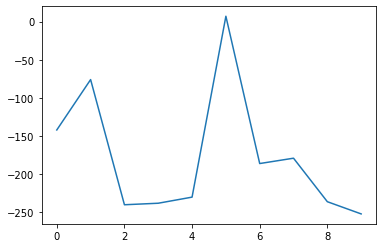

In [10]:
# Training Balancing Agent
max_episode_num = 10

env = ControlableLunarLander()
vertical_agent = A2CVerticalController(env)

# train
vertical_agent.train(max_episode_num)

# result
vertical_agent.plot_result()

env.close()

학습이 잘 안되는 요인
1. 빨리 떨어졌을 때 받는 리워드가 더 크다(즉, local minima에 빠짐)

In [ ]:
# Training Balancing Agent
max_episode_num = 1000

# train
vertical_agent.train(max_episode_num)

# result
vertical_agent.plot_result()

env.close()

Episode:  1 Time:  202 Reward:  [-110]
Critic value:  tf.Tensor([[23.529516]], shape=(1, 1), dtype=float32)
Episode:  2 Time:  191 Reward:  [-215]
Episode:  3 Time:  157 Reward:  [-243]
Episode:  4 Time:  202 Reward:  [-202]
Episode:  5 Time:  144 Reward:  [-206]
Episode:  6 Time:  202 Reward:  [-202]
Episode:  7 Time:  202 Reward:  [-20]
Episode:  8 Time:  202 Reward:  [-202]
Episode:  9 Time:  180 Reward:  [-280]
Episode:  10 Time:  202 Reward:  [-54]
Episode:  11 Time:  130 Reward:  [-230]
Critic value:  tf.Tensor([[9.235971]], shape=(1, 1), dtype=float32)
Episode:  12 Time:  128 Reward:  [-186]
Episode:  13 Time:  202 Reward:  [-148]
Episode:  14 Time:  202 Reward:  [-202]
Episode:  15 Time:  202 Reward:  [-202]
Episode:  16 Time:  202 Reward:  [-114]
Episode:  17 Time:  167 Reward:  [-265]
Episode:  18 Time:  189 Reward:  [-123]
Episode:  19 Time:  202 Reward:  [-202]
Episode:  20 Time:  172 Reward:  [-146]
Episode:  21 Time:  193 Reward:  [-261]
Critic value:  tf.Tensor([[10.7456

Episode:  174 Time:  162 Reward:  [-262]
Episode:  175 Time:  202 Reward:  [-182]
Episode:  176 Time:  202 Reward:  [-166]
Episode:  177 Time:  202 Reward:  [-176]
Episode:  178 Time:  157 Reward:  [-215]
Episode:  179 Time:  202 Reward:  [-202]
Episode:  180 Time:  202 Reward:  [-164]
Episode:  181 Time:  202 Reward:  [-202]
Critic value:  tf.Tensor([[25.75463]], shape=(1, 1), dtype=float32)
Episode:  182 Time:  130 Reward:  [-186]
Episode:  183 Time:  151 Reward:  [-209]
Episode:  184 Time:  140 Reward:  [-206]
Episode:  185 Time:  165 Reward:  [-265]
Episode:  186 Time:  165 Reward:  [-203]
Episode:  187 Time:  180 Reward:  [-266]
Episode:  188 Time:  202 Reward:  [-202]
Episode:  189 Time:  202 Reward:  [-176]
Episode:  190 Time:  202 Reward:  [-202]
Episode:  191 Time:  202 Reward:  [-202]
Critic value:  tf.Tensor([[27.034645]], shape=(1, 1), dtype=float32)
Episode:  192 Time:  202 Reward:  [-162]
Episode:  193 Time:  202 Reward:  [-200]
Episode:  194 Time:  199 Reward:  [-269]
Ep